# Experiment Workbench

In [1]:
import os, sys, math, datetime
import pathlib
from pathlib import Path
import numpy as np
import random
from matplotlib import pyplot as plt
import PIL
import PIL.Image
import seaborn as sns

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D,DepthwiseConv2D, MaxPooling2D, AvgPool2D, GlobalAveragePooling2D, BatchNormalization, Concatenate
from tensorflow.keras.layers import ReLU
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
 
# Import the necessary MLTK APIs
from mltk.core import view_model, summarize_model, profile_model

# import workbench.config.config
from workbench.config.config import initialize
from workbench.utils.utils import create_filepaths
from workbench.utils.utils import parse_model_name

#from dotenv import load_dotenv
import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint
#import deeplake


In [2]:
print("Tensorflow version " + tf.__version__)
AUTOTUNE = tf.data.AUTOTUNE

# Confirm that TensorFlow can access GPU
device_name = tf.test.gpu_device_name()
if not device_name:
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Tensorflow version 2.10.0
Found GPU at: /device:GPU:0


In [3]:
# TODO:

# Add learning rate schedule

# tf.compat.v1.disable_eager_execution()

In [4]:
# DANGER ZONE: Disable warning messages

import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

In [5]:


# set the random seeds
os.environ["TF_CUDNN_DETERMINISTIC"]= "1"
random.seed(hash("setting_random seeds") % 2**32 -1)
np.random.seed(hash("improves reproducibility") % 2**32 -1)
tf.random.set_seed(hash("by removing stochasticity") %2 *32 -1 )

In [6]:
models_dir = initialize()

# Get the model

In [7]:
global model_name
model_name = "efficientNetB0_1_96_c1_o3_keras"
#model_name = "mobilenetv1_0.1_96_c3_o3_l1"

In [8]:
models_path, models_summary_path, models_image_path, models_layer_df_path, models_tf_path, models_tflite_path, models_tflite_opt_path = create_filepaths(model_name)

i:\tinyml\tiny_cnn\models


In [9]:
model = keras.models.load_model(models_tf_path)

In [10]:
global base_model_name
global alpha
global resolution
global channels
global classes
global variation
global early_stopping_patience

In [11]:
base_model_name, alpha, resolution, channels, classes, variation = model_name.split("_")

In [12]:
alpha = float(alpha)
resolution = int(resolution)
classes = int(classes.strip("o"))

In [13]:
# Start a Tensorboard session
%load_ext tensorboard

In [14]:
#os.environ['WANDB_NOTEBOOK_NAME'] = 'Experiment Workbench'

IMG_HEIGHT = resolution
IMG_WIDTH = resolution
BATCH_SIZE = 32
EPOCHS = 100
#LOGGING_STEPS = 64
MOMENTUM = 0.9
LR = 0.001
DROPOUT = 0.5
early_stopping_patience = 30

PROJECT = base_model_name
#PROJECT = "tiny_cnn troubleshooting"
SEED = 42
tf.random.set_seed(SEED) # global seed for tensorflow random parts, like dropout
shuffle_seed = 42

# Prepare the Lemon Quality Dataset

In [15]:
dataset_path = Path.cwd().joinpath("datasets", "lemon_dataset")
dataset_path.exists()

True

In [16]:
def get_lemon_quality_dataset(dataset_path, img_width, img_height, batch_size, channels, normalize=True):
    """ Fetches the lemon quality dataset and prints dataset info. It normalizes the image data to range [0,1] by default.

    Args: 
        dataset_path (Path): the file location of the dataset. Subfolders "train", "test", and "val" are expected.
        normalize (boolean): Normalizes the image data to range [0, 1]. Default: True

    Returns:
        (train_ds, val_ds, test_ds, class_names) (tuple(tf.datasets)): Tensorflow datasets for train, validation and test.
    
    """
    if dataset_path.exists():
        try:
            train_dir = dataset_path.joinpath("train")
            val_dir = dataset_path.joinpath( "val")
            test_dir = dataset_path.joinpath( "test")
        except:
            print(f"Please check the folder structure of {dataset_path}.")
            raise

    channels = int(channels.strip("c"))
    if channels==1:
        color_mode = "grayscale"
    else:
        color_mode = "rgb" 

    # create the labels list to avoid inclusion of .ipynb checkpoints
    #labels = ["bad_quality", "empty_background", "good_quality"]

    print("Preparing training dataset...")        
    train_ds = tf.keras.utils.image_dataset_from_directory(
        train_dir,
        subset=None,
        seed=shuffle_seed,
        image_size=((img_height, img_width)),
        #labels=labels,
        batch_size=batch_size,
        color_mode=color_mode)
    

    class_names = train_ds.class_names


    print("Preparing validation dataset...")    
    val_ds = tf.keras.utils.image_dataset_from_directory(
        val_dir,
        subset=None,
        seed=shuffle_seed,
        image_size=(img_height, img_width),
        batch_size=batch_size,
        color_mode=color_mode)
    

    print("Preparing test dataset...")    
    test_ds = tf.keras.utils.image_dataset_from_directory(
        test_dir,
        subset=None,
        seed=shuffle_seed,
        image_size=(img_height, img_width),
        batch_size=batch_size,
        color_mode=color_mode)
    
    # Create a data augmentation stage with horizontal flipping, rotations, zooms
    data_augmentation = keras.Sequential(
        [
            tf.keras.layers.RandomFlip("horizontal"),
            tf.keras.layers.RandomRotation(0.1),
            tf.keras.layers.RandomZoom(0.1),
        ]
        )

    #train_ds= train_ds.map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=tf.data.AUTOTUNE )

    
    # Normalize the data to the range [0, 1]
    if normalize:
        normalization_layer = tf.keras.layers.Rescaling(1./255, offset=-1)

        train_ds= train_ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=tf.data.AUTOTUNE)
        val_ds= val_ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=tf.data.AUTOTUNE)
        test_ds= test_ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    else:
        pass

    print (f"Class names: {class_names}")
    print(train_ds.element_spec)
    print(f"Normalize: {normalize}")
    return (train_ds, val_ds, test_ds, class_names)

In [17]:
channels

'c1'

In [18]:
train_ds, val_ds, test_ds, labels = get_lemon_quality_dataset(dataset_path, IMG_WIDTH, IMG_HEIGHT, BATCH_SIZE, channels)

Preparing training dataset...
Found 2021 files belonging to 3 classes.
Preparing validation dataset...
Found 252 files belonging to 3 classes.
Preparing test dataset...
Found 255 files belonging to 3 classes.
Class names: ['bad_quality', 'empty_background', 'good_quality']
(TensorSpec(shape=(None, 96, 96, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
Normalize: True


['bad_quality', 'empty_background', 'good_quality']


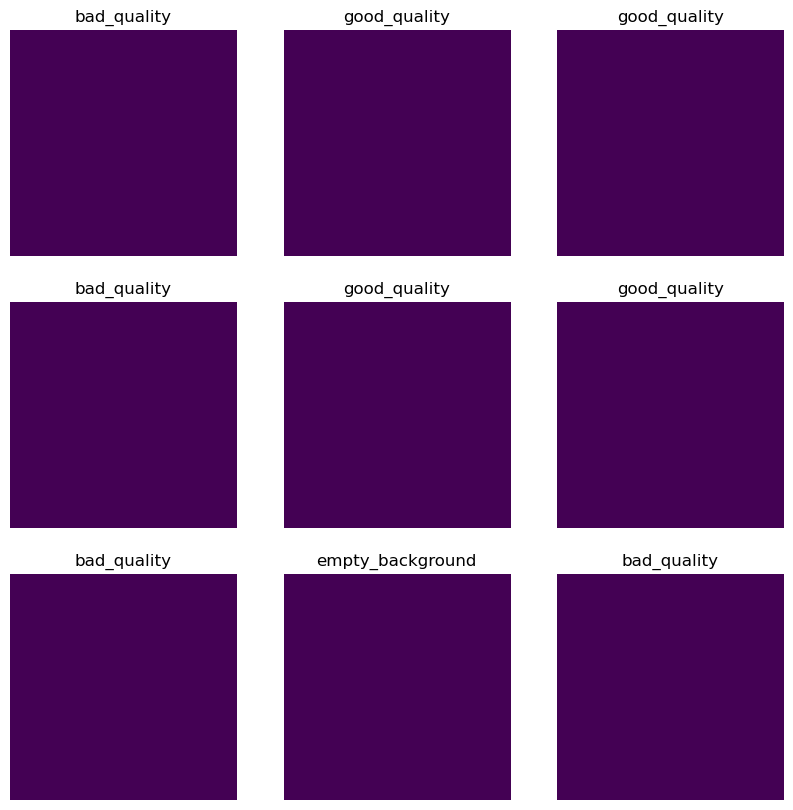

In [19]:
class_names = labels
print(class_names)

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [20]:
train_ds

<ParallelMapDataset element_spec=(TensorSpec(shape=(None, 96, 96, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [21]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    print(labels_batch)
    break

(32, 96, 96, 1)
(32,)
tf.Tensor([0 2 1 0 0 2 0 0 2 0 2 0 0 1 0 1 2 0 0 0 2 1 0 2 1 0 1 0 2 2 0 0], shape=(32,), dtype=int32)


In [22]:
# classes = len(labels)
# print(f"The dataset contains {classes } classes.")

# Define the model

In [23]:
logdir = os.path.join("logs", model_name, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
root_logdir = os.getcwd()

In [24]:
#wandb.__version__

In [25]:
tf.keras.backend.clear_session()

# optimize the data flow
AUTOTUNE = tf.data.AUTOTUNE
#train_ds = train_ds.cache().prefetch(AUTOTUNE)
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [26]:
#api = wandb.Api()
api = wandb.Api(timeout=19)

In [27]:
# code taken from https://www.tensorflow.org/guide/keras/custom_callback#examples_of_keras_callback_applications

class EarlyStoppingAtMinLoss(keras.callbacks.Callback):
    """Stop training when the loss is at its min, i.e. the loss stops decreasing.

  Arguments:
      patience: Number of epochs to wait after min has been hit. After this
      number of no improvement, training stops.
  """

    def __init__(self, patience=0):
        super(EarlyStoppingAtMinLoss, self).__init__()
        self.patience = patience
        # best_weights to store the weights at which the minimum loss occurs.
        self.best_weights = None

    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        self.best = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get("loss")
        if np.less(current, self.best):
            self.best = current
            self.wait = 0
            # Record the best weights if current results is better (less).
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))


In [28]:
class EarlyStoppingAtMaxValAccuracy(keras.callbacks.Callback):
    """Stop training when the loss is at its min, i.e. the loss stops decreasing.

  Arguments:
      patience: Number of epochs to wait after max has been hit. After this
      number of no improvement, training stops.
  """

    def __init__(self, patience=30):
        super(EarlyStoppingAtMaxValAccuracy, self).__init__()
        self.patience = patience
        # best_weights to store the weights at which the minimum loss occurs.
        self.best_weights = None

    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        self.best = 0
        self.best_epoch = 0
        self.best_epoch_loss = np.Infinity

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get("val_accuracy")
        if np.greater(current, self.best):
            self.best = current
            self.best_epoch = epoch
            self.best_epoch_loss = logs.get("val_loss")
            self.wait = 0
            # Record the best weights if current results is better (less).
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)

        metrics = dict()
        metrics["best_epoch"] = self.best_epoch
        metrics["best_val_accuracy"] = self.best
        metrics["best_epoch_loss"] = self.best_epoch_loss

        wandb.log(metrics)



    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))
        


In [29]:
#os.environ["WANDB_MODE"] = "online"
os.environ["WANDB_MODE"] = "offline"
def train_model_wandb(model):

        # solve issue from: https://github.com/wandb/wandb/issues/3536
        if len(wandb.patched["tensorboard"]) > 0:
                wandb.tensorboard.unpatch()
                
        # Configure Tensorboard root log directory to read the debugging information
        wandb.tensorboard.patch(root_logdir=root_logdir)
        # wandb.tensorboard.patch(root_logdir="wandb.run.dir")
        
        # Generate run ids
        id = wandb.util.generate_id()

        run = wandb.init(
                # Set the project where this run will be logged
                project=PROJECT, 
                id = id, 
                resume="allow",
                sync_tensorboard=True
                )

        # Specify the configuration variables
        config = wandb.config
        
        config.batch_size = BATCH_SIZE
        #config.dropout =DROPOUT
        config.learn_rate = LR
        config.momentum = MOMENTUM
        #config.decay = 1e-6
        config.epochs = EPOCHS
        config.classes = classes
        config.id = id
        config.architecture = model_name
        

        # enable Tensorflow Debugging
        #tf.debugging.experimental.enable_dump_debug_info("./logs/debug", 
        #        tensor_debug_mode="FULL_HEALTH", circular_buffer_size=-1)

        optimizer = tf.keras.optimizers.SGD(learning_rate=LR, momentum=MOMENTUM)
        config.optimizer = optimizer._name

        model.compile(optimizer=optimizer,
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

        logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir= wandb.run.dir, histogram_freq=10, update_freq="epoch") #, profile_batch="10, 20")
        #tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir= logdir, histogram_freq=1)
        #wandb_callback = WandbCallback()# input_type="image", labels=labels) #, validation_data = val_ds.as_numpy_iterator())

        def lr_schedule(epoch):
                """
                Returns a custom learning rate that decreases as epochs progress.
                """
                learning_rate = LR
                if epoch > 20:
                        learning_rate = 0.0001
                tf.summary.scalar('learning rate', data=learning_rate, step=epoch)
                return learning_rate

        lr_callback = LearningRateScheduler(lr_schedule)

        best_model_path = Path(wandb.run.dir).joinpath(f"best_model")

        checkpoint = WandbModelCheckpoint(best_model_path,
                monitor="val_accuracy",
                save_best_only=True,
                save_freq="epoch")

        global early_stopping_patience
        early_stopping = EarlyStopping(monitor="val_accuracy", patience=early_stopping_patience)

        callbacks =[
                tensorboard_callback,
                lr_callback,
                #wandb_callback,
                WandbMetricsLogger(),
                checkpoint,
                #early_stopping,
                EarlyStoppingAtMaxValAccuracy()
        ]

        history = model.fit(train_ds,
                epochs=EPOCHS, 
                validation_data=val_ds, 
                callbacks=callbacks
        )

        #wandb.save("last_model.h5")




        #best_model = keras.models.load_model(best_model_path) # not needed due to "restore_best_weights=True"

        y_val_true = np.concatenate([y for x, y in val_ds], axis=0)
        y_val_pred = model.predict(val_ds).argmax(axis=1)

        results = model.evaluate(test_ds, batch_size=BATCH_SIZE)
        print("test loss, test acc:", results)
        wandb.log({
                "test_loss" : results[0],
                "test_accuracy" : results[1]
        })

        # log data for the confusion matrix
        wandb.log({"conf_mat" : wandb.plot.confusion_matrix(probs=None,
                        y_true=y_val_true, preds=y_val_pred,
                        class_names=labels)})


        run.finish()
        return history, model, run.id

In [30]:
wandb.finish()
history, model, run_id = train_model_wandb(model)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: susbrock. Use `wandb login --relogin` to force relogin


wandb: WARNING When using `save_best_only`, ensure that the `filepath` argument contains formatting placeholders like `{epoch:02d}` or `{batch:02d}`. This ensures correct interpretation of the logged artifacts.


Epoch 1/100
64/64 [==============================] - ETA: 0s - loss: 1.5062 - accuracy: 0.5982INFO:tensorflow:Assets written to: i:\tinyml\tiny_cnn\wandb\run-20221227_084459-1cs4d6vn\files\best_model\assets


INFO:tensorflow:Assets written to: i:\tinyml\tiny_cnn\wandb\run-20221227_084459-1cs4d6vn\files\best_model\assets
wandb: Adding directory to artifact (i:\tinyml\tiny_cnn\wandb\run-20221227_084459-1cs4d6vn\files\best_model)... Done. 0.3s


64/64 [==============================] - 172s 2s/step - loss: 1.5062 - accuracy: 0.5982 - val_loss: 1.0485 - val_accuracy: 0.4444 - lr: 0.0010
Epoch 2/100
64/64 [==============================] - ETA: 0s - loss: 0.7685 - accuracy: 0.7412

wandb: Adding directory to artifact (i:\tinyml\tiny_cnn\wandb\run-20221227_084459-1cs4d6vn\files\best_model)... Done. 0.1s


64/64 [==============================] - 45s 702ms/step - loss: 0.7685 - accuracy: 0.7412 - val_loss: 1.0742 - val_accuracy: 0.4444 - lr: 0.0010
Epoch 3/100
64/64 [==============================] - ETA: 0s - loss: 0.5101 - accuracy: 0.8318

wandb: Adding directory to artifact (i:\tinyml\tiny_cnn\wandb\run-20221227_084459-1cs4d6vn\files\best_model)... Done. 0.1s


64/64 [==============================] - 45s 704ms/step - loss: 0.5101 - accuracy: 0.8318 - val_loss: 1.4918 - val_accuracy: 0.3770 - lr: 0.0010
Epoch 4/100
64/64 [==============================] - ETA: 0s - loss: 0.3922 - accuracy: 0.8684

wandb: Adding directory to artifact (i:\tinyml\tiny_cnn\wandb\run-20221227_084459-1cs4d6vn\files\best_model)... Done. 0.1s


64/64 [==============================] - 45s 707ms/step - loss: 0.3922 - accuracy: 0.8684 - val_loss: 1.5002 - val_accuracy: 0.3770 - lr: 0.0010
Epoch 5/100
64/64 [==============================] - ETA: 0s - loss: 0.3676 - accuracy: 0.8699

wandb: Adding directory to artifact (i:\tinyml\tiny_cnn\wandb\run-20221227_084459-1cs4d6vn\files\best_model)... Done. 0.1s


64/64 [==============================] - 45s 706ms/step - loss: 0.3676 - accuracy: 0.8699 - val_loss: 2.7952 - val_accuracy: 0.1786 - lr: 0.0010
Epoch 6/100
64/64 [==============================] - ETA: 0s - loss: 0.2656 - accuracy: 0.8991

wandb: Adding directory to artifact (i:\tinyml\tiny_cnn\wandb\run-20221227_084459-1cs4d6vn\files\best_model)... Done. 0.1s


64/64 [==============================] - 45s 708ms/step - loss: 0.2656 - accuracy: 0.8991 - val_loss: 4.1441 - val_accuracy: 0.1786 - lr: 0.0010
Epoch 7/100
64/64 [==============================] - ETA: 0s - loss: 0.2016 - accuracy: 0.9263

wandb: Adding directory to artifact (i:\tinyml\tiny_cnn\wandb\run-20221227_084459-1cs4d6vn\files\best_model)... Done. 0.1s


64/64 [==============================] - 46s 711ms/step - loss: 0.2016 - accuracy: 0.9263 - val_loss: 5.5774 - val_accuracy: 0.1786 - lr: 0.0010
Epoch 8/100
64/64 [==============================] - ETA: 0s - loss: 0.2062 - accuracy: 0.9273

wandb: Adding directory to artifact (i:\tinyml\tiny_cnn\wandb\run-20221227_084459-1cs4d6vn\files\best_model)... Done. 0.1s


64/64 [==============================] - 43s 667ms/step - loss: 0.2062 - accuracy: 0.9273 - val_loss: 7.1389 - val_accuracy: 0.1786 - lr: 0.0010
Epoch 9/100
64/64 [==============================] - ETA: 0s - loss: 0.1755 - accuracy: 0.9436

wandb: Adding directory to artifact (i:\tinyml\tiny_cnn\wandb\run-20221227_084459-1cs4d6vn\files\best_model)... Done. 0.1s


64/64 [==============================] - 33s 512ms/step - loss: 0.1755 - accuracy: 0.9436 - val_loss: 7.4202 - val_accuracy: 0.1786 - lr: 0.0010
Epoch 10/100
64/64 [==============================] - ETA: 0s - loss: 0.1415 - accuracy: 0.9426

wandb: Adding directory to artifact (i:\tinyml\tiny_cnn\wandb\run-20221227_084459-1cs4d6vn\files\best_model)... Done. 0.1s


64/64 [==============================] - 34s 525ms/step - loss: 0.1415 - accuracy: 0.9426 - val_loss: 3.1637 - val_accuracy: 0.2381 - lr: 0.0010
Epoch 11/100
64/64 [==============================] - ETA: 0s - loss: 0.1733 - accuracy: 0.9332INFO:tensorflow:Assets written to: i:\tinyml\tiny_cnn\wandb\run-20221227_084459-1cs4d6vn\files\best_model\assets


INFO:tensorflow:Assets written to: i:\tinyml\tiny_cnn\wandb\run-20221227_084459-1cs4d6vn\files\best_model\assets
wandb: Adding directory to artifact (i:\tinyml\tiny_cnn\wandb\run-20221227_084459-1cs4d6vn\files\best_model)... Done. 0.2s


64/64 [==============================] - 104s 2s/step - loss: 0.1733 - accuracy: 0.9332 - val_loss: 0.6049 - val_accuracy: 0.7976 - lr: 0.0010
Epoch 12/100
64/64 [==============================] - ETA: 0s - loss: 0.1148 - accuracy: 0.9584INFO:tensorflow:Assets written to: i:\tinyml\tiny_cnn\wandb\run-20221227_084459-1cs4d6vn\files\best_model\assets


INFO:tensorflow:Assets written to: i:\tinyml\tiny_cnn\wandb\run-20221227_084459-1cs4d6vn\files\best_model\assets
wandb: Adding directory to artifact (i:\tinyml\tiny_cnn\wandb\run-20221227_084459-1cs4d6vn\files\best_model)... Done. 0.2s


64/64 [==============================] - 95s 1s/step - loss: 0.1148 - accuracy: 0.9584 - val_loss: 0.2157 - val_accuracy: 0.9127 - lr: 0.0010
Epoch 13/100
64/64 [==============================] - ETA: 0s - loss: 0.1754 - accuracy: 0.9312INFO:tensorflow:Assets written to: i:\tinyml\tiny_cnn\wandb\run-20221227_084459-1cs4d6vn\files\best_model\assets


INFO:tensorflow:Assets written to: i:\tinyml\tiny_cnn\wandb\run-20221227_084459-1cs4d6vn\files\best_model\assets
wandb: Adding directory to artifact (i:\tinyml\tiny_cnn\wandb\run-20221227_084459-1cs4d6vn\files\best_model)... Done. 0.3s


64/64 [==============================] - 92s 1s/step - loss: 0.1754 - accuracy: 0.9312 - val_loss: 0.2251 - val_accuracy: 0.9206 - lr: 0.0010
Epoch 14/100
64/64 [==============================] - ETA: 0s - loss: 0.1737 - accuracy: 0.9352

wandb: Adding directory to artifact (i:\tinyml\tiny_cnn\wandb\run-20221227_084459-1cs4d6vn\files\best_model)... Done. 0.1s


64/64 [==============================] - 34s 531ms/step - loss: 0.1737 - accuracy: 0.9352 - val_loss: 0.2451 - val_accuracy: 0.8929 - lr: 0.0010
Epoch 15/100
64/64 [==============================] - ETA: 0s - loss: 0.1102 - accuracy: 0.9599INFO:tensorflow:Assets written to: i:\tinyml\tiny_cnn\wandb\run-20221227_084459-1cs4d6vn\files\best_model\assets


INFO:tensorflow:Assets written to: i:\tinyml\tiny_cnn\wandb\run-20221227_084459-1cs4d6vn\files\best_model\assets
wandb: Adding directory to artifact (i:\tinyml\tiny_cnn\wandb\run-20221227_084459-1cs4d6vn\files\best_model)... Done. 0.3s


64/64 [==============================] - 91s 1s/step - loss: 0.1102 - accuracy: 0.9599 - val_loss: 0.1150 - val_accuracy: 0.9484 - lr: 0.0010
Epoch 16/100
64/64 [==============================] - ETA: 0s - loss: 0.1337 - accuracy: 0.9540

wandb: Adding directory to artifact (i:\tinyml\tiny_cnn\wandb\run-20221227_084459-1cs4d6vn\files\best_model)... Done. 0.1s


64/64 [==============================] - 34s 524ms/step - loss: 0.1337 - accuracy: 0.9540 - val_loss: 0.3459 - val_accuracy: 0.8810 - lr: 0.0010
Epoch 17/100
64/64 [==============================] - ETA: 0s - loss: 0.1247 - accuracy: 0.9550INFO:tensorflow:Assets written to: i:\tinyml\tiny_cnn\wandb\run-20221227_084459-1cs4d6vn\files\best_model\assets


INFO:tensorflow:Assets written to: i:\tinyml\tiny_cnn\wandb\run-20221227_084459-1cs4d6vn\files\best_model\assets
wandb: Adding directory to artifact (i:\tinyml\tiny_cnn\wandb\run-20221227_084459-1cs4d6vn\files\best_model)... Done. 0.1s
wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=9 sec). Create a new API with an integer timeout larger than 9, e.g., `api = wandb.Api(timeout=19)` to increase the graphql timeout.


64/64 [==============================] - 336s 5s/step - loss: 0.1247 - accuracy: 0.9550 - val_loss: 0.1031 - val_accuracy: 0.9563 - lr: 0.0010
Epoch 18/100
64/64 [==============================] - ETA: 0s - loss: 0.2092 - accuracy: 0.9312

wandb: Adding directory to artifact (i:\tinyml\tiny_cnn\wandb\run-20221227_084459-1cs4d6vn\files\best_model)... Done. 0.1s


64/64 [==============================] - 51s 796ms/step - loss: 0.2092 - accuracy: 0.9312 - val_loss: 4.8778 - val_accuracy: 0.7619 - lr: 0.0010
Epoch 19/100
64/64 [==============================] - ETA: 0s - loss: 0.1640 - accuracy: 0.9500

wandb: Adding directory to artifact (i:\tinyml\tiny_cnn\wandb\run-20221227_084459-1cs4d6vn\files\best_model)... Done. 0.1s


64/64 [==============================] - 52s 804ms/step - loss: 0.1640 - accuracy: 0.9500 - val_loss: 1.7237 - val_accuracy: 0.8571 - lr: 0.0010
Epoch 20/100
37/64 [================>.............] - ETA: 23s - loss: 0.1427 - accuracy: 0.9468

KeyboardInterrupt: 

In [ ]:
#run_id = "1ke0yso4"

In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_ds, batch_size=BATCH_SIZE)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
# print("Generate predictions for 3 samples")
# predictions = model.predict(x_test[:3])
# print("predictions shape:", predictions.shape)

Evaluate on test data
8/8 [==============================] - 0s 8ms/step - loss: 0.1677 - accuracy: 0.9412
test loss, test acc: [0.1676630973815918, 0.9411764740943909]


In [ ]:
# entity = "susbrock"


# run = api.run(f"{entity}/{PROJECT}/{run_id}")
# run.summary["test_accuracy"] = results[1]
# run.summary["test_loss"] = results[0]
# run.summary.update()

In [ ]:
results

[0.1676630973815918, 0.9411764740943909]

In [ ]:
scores = model.evaluate(val_ds, verbose=0)

In [ ]:
scores

[0.14160692691802979, 0.9404761791229248]

In [ ]:
model.metrics_names

['loss', 'accuracy']

In [ ]:
val_predictions = model.predict(val_ds)

8/8 [==============================] - 0s 6ms/step


In [ ]:
top_pred_ids = val_predictions.argmax(axis=1)

In [ ]:
y_true = np.concatenate([y for x, y in val_ds], axis=0)
y_true

array([0, 0, 1, 2, 0, 1, 2, 1, 2, 2, 2, 2, 2, 0, 2, 2, 2, 1, 0, 2, 0, 1,
       1, 0, 2, 2, 2, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 1, 1, 2, 2, 0, 2, 0,
       2, 2, 2, 0, 1, 0, 1, 0, 0, 2, 0, 2, 0, 0, 2, 2, 0, 1, 2, 0, 2, 0,
       2, 1, 2, 2, 1, 1, 0, 2, 1, 0, 2, 0, 1, 2, 2, 2, 0, 0, 0, 0, 0, 2,
       0, 2, 0, 2, 0, 0, 0, 0, 0, 1, 0, 2, 2, 1, 1, 1, 1, 1, 2, 0, 0, 0,
       2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 1, 0, 0, 2, 1, 0, 2, 0, 2, 1, 0,
       0, 1, 2, 1, 2, 2, 2, 1, 1, 0, 2, 1, 2, 0, 0, 2, 1, 0, 0, 0, 2, 0,
       0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 1, 2, 2, 2, 1, 1, 2, 0, 2,
       1, 2, 0, 2, 2, 2, 0, 0, 0, 2, 1, 0, 0, 0, 2, 2, 0, 1, 2, 0, 2, 0,
       1, 0, 2, 2, 2, 2, 1, 2, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2,
       2, 0, 0, 2, 1, 2, 0, 2, 0, 2, 0, 0, 2, 0, 1, 1, 2, 1, 2, 2, 0, 2,
       2, 0, 2, 1, 2, 2, 2, 1, 2, 0])

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, top_pred_ids, num_classes=classes)
    # list(ds_test.map(lambda x, y: y)),
    # predict_class_label_number(test_data),
    # num_classes=len(label_names))
    
confusion_mtx

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[ 87,   0,   8],
       [  0,  45,   0],
       [  7,   0, 105]])>

In [ ]:
def show_confusion_matrix(cm, labels):
  plt.figure(figsize=(6, 6))
  sns.heatmap(cm, xticklabels=labels, yticklabels=labels, 
              annot=True, fmt='g')
  plt.xlabel('Prediction')
  plt.ylabel('Label')
  plt.show()

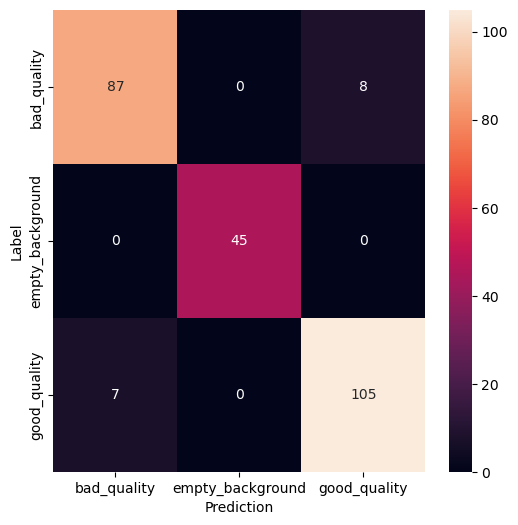

In [ ]:
show_confusion_matrix(confusion_mtx, labels)

In [ ]:
top_pred_ids

array([0, 0, 1, 0, 0, 1, 2, 1, 2, 2, 2, 0, 2, 0, 2, 2, 2, 1, 0, 2, 0, 1,
       1, 0, 2, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 1, 2, 2, 0, 2, 2,
       2, 2, 2, 0, 1, 0, 1, 0, 0, 2, 0, 2, 2, 0, 2, 2, 0, 1, 2, 0, 2, 0,
       0, 1, 2, 2, 1, 1, 0, 2, 1, 0, 2, 0, 1, 2, 2, 2, 2, 0, 0, 0, 0, 2,
       0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 2, 1, 1, 1, 1, 1, 2, 0, 0, 0,
       2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 1, 0, 0, 2, 1, 0, 2, 0, 2, 1, 0,
       0, 1, 2, 1, 2, 2, 2, 1, 1, 0, 2, 1, 2, 0, 0, 2, 1, 2, 2, 0, 2, 0,
       0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 1, 2, 2, 2, 1, 1, 2, 0, 2,
       1, 2, 0, 2, 2, 2, 0, 0, 0, 2, 1, 0, 0, 0, 2, 2, 2, 1, 2, 0, 2, 0,
       1, 0, 2, 2, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 2,
       2, 0, 0, 2, 1, 2, 0, 2, 2, 2, 0, 0, 2, 0, 1, 1, 2, 1, 2, 2, 0, 2,
       2, 0, 2, 1, 2, 2, 2, 1, 2, 0], dtype=int64)

In [ ]:
val_predictions

array([[9.98634875e-01, 9.70571637e-06, 1.35528960e-03],
       [8.69496107e-01, 4.40537668e-04, 1.30063385e-01],
       [7.81433773e-04, 9.97772396e-01, 1.44612964e-03],
       [6.80700362e-01, 3.81848635e-03, 3.15481186e-01],
       [9.88369346e-01, 7.42694363e-04, 1.08880112e-02],
       [6.56643359e-04, 9.96850312e-01, 2.49302411e-03],
       [2.74405786e-04, 5.06958633e-04, 9.99218583e-01],
       [1.04353926e-03, 9.97477710e-01, 1.47872430e-03],
       [3.42178321e-03, 2.30503196e-04, 9.96347725e-01],
       [4.78224829e-03, 4.46792808e-04, 9.94770944e-01],
       [6.82326092e-04, 2.85239337e-04, 9.99032497e-01],
       [9.61542904e-01, 4.76013607e-04, 3.79809998e-02],
       [5.11775771e-03, 7.97758694e-04, 9.94084537e-01],
       [9.69432414e-01, 1.63845043e-03, 2.89291833e-02],
       [8.24281131e-04, 2.05236356e-04, 9.98970509e-01],
       [2.09083818e-02, 1.71040636e-04, 9.78920519e-01],
       [7.18630385e-03, 1.15160004e-03, 9.91662145e-01],
       [2.72379047e-03, 9.95868

## Code reserved for troubleshooting

In [ ]:
def mobilenet_v1_keras(input_shape, classes=classes, alpha=alpha):
    model = tf.keras.applications.mobilenet.MobileNet(
        input_shape=input_shape,
        alpha=alpha,
        depth_multiplier=1,
        dropout=0.001,
        include_top=True,
        weights=None, #'imagenet'
        input_tensor=None,
        pooling=None,
        classes=classes,
        classifier_activation='softmax',
        #**kwargs
    )

    #model._name = model.name + "_keras" # model.name cannot be overritten

    return model
    #model = mobilenet_v1_keras((IMG_WIDTH, IMG_HEIGHT, 3), classes=classes, alpha=alpha)

In [ ]:
#os.environ["WANDB_MODE"] = "online"
def train_model(model):

        # solve issue from: https://github.com/wandb/wandb/issues/3536
        # if len(wandb.patched["tensorboard"]) > 0:
        #         wandb.tensorboard.unpatch()
                
        # Configure Tensorboard root log directory to read the debugging information
        #wandb.tensorboard.patch(root_logdir=root_logdir)
        # wandb.tensorboard.patch(root_logdir="wandb.run.dir")
        
        # wandb.init(
        #         # Set the project where this run will be logged
        #         project=PROJECT, 
        #         # Track hyperparameters and run metadata
        #         #config={
        #         #"learning_rate": LR,
        #         #"epochs": EPOCHS,
        #         #},
        #         sync_tensorboard=True
        #         )



        # config = wandb.config
        # # Specify the configuration variables
        # config.batch_size = BATCH_SIZE
        # config.dropout =DROPOUT
        # config.learn_rate = LR
        # #config.decay = 1e-6
        # #config.momentum = 0.9
        # config.epochs = EPOCHS
        # config.classes = classes
        

        # enable Tensorflow Debugging
        #tf.debugging.experimental.enable_dump_debug_info("./logs/debug", 
        #        tensor_debug_mode="FULL_HEALTH", circular_buffer_size=-1)

        #model = mobilenet
        model.compile(optimizer='adam',
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

        logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
        #tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir= wandb.run.dir, histogram_freq=10, update_freq="epoch") #, profile_batch="10, 20")
        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir= logdir) #, histogram_freq=1)
        #wandb_callback = WandbCallback()# input_type="image", labels=labels) #, validation_data = val_ds.as_numpy_iterator())

        early_stopping = EarlyStopping(monitor="val_accuracy", patience=50)

        #checkpoint = ModelCheckpoint("my_tiny_model", save_weights_only=True)

        callbacks =[
                #tensorboard_callback,
                #wandb_callback,
                #WandbMetricsLogger(),
                #checkpoint,
                #early_stopping
        ]

        history = model.fit(train_ds,
                epochs=EPOCHS, 
                validation_data=val_ds, 
                callbacks=callbacks
        )

        # wandb.log({
        #         "loss": history.history["loss"],
        #         "accuracy": history.history["accuracy"],
        #         "val_loss": history.history["val_loss"],
        #         "val_accuracy": history.history["val_accuracy"],                                
        # })
        
        #wandb.finish()
        return history, model


In [ ]:
# model.compile(optimizer='adam',
#                 loss='sparse_categorical_crossentropy',
#                 metrics=['accuracy'])

In [ ]:
# history = model.fit(train_ds,
#                 epochs=EPOCHS, 
#                 validation_data=val_ds
#         )

In [ ]:
#history.history["loss"]
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

In [ ]:
history.params

{'verbose': 1, 'epochs': 100, 'steps': 64}